<a href="https://colab.research.google.com/github/rohitbisen-12/IIIT_PRO_MINOR_LAB/blob/main/Module_09_Lab_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 9: Convolutional Neural Networks

Lab 4

In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-09 18:01:52--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.156.201.114, 108.156.201.105, 108.156.201.104, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.156.201.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  61.8MB/s    in 0.7s    

2024-05-09 18:01:53 (61.8 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


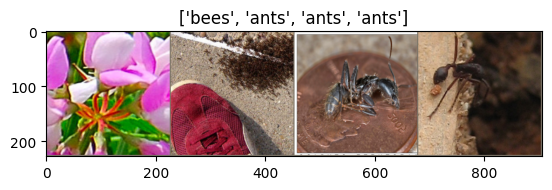

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 29.2MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5710 Acc: 0.7213

Epoch 1/4
----------
Loss: 0.5352 Acc: 0.7664

Epoch 2/4
----------
Loss: 0.4517 Acc: 0.8074

Epoch 3/4
----------
Loss: 0.3728 Acc: 0.8402

Epoch 4/4
----------
Loss: 0.4400 Acc: 0.8156



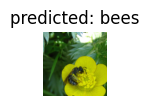

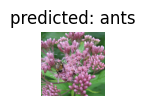

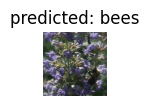

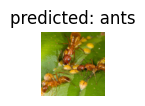

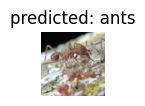

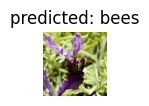

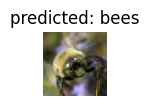

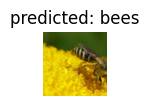

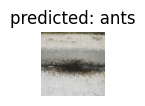

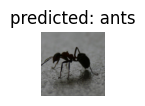

In [ ]:
visualize_model(model_ft)

Questions:

1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?



Answer Q1)

Data augmentation techniques like resize, crop, flip, rotation, and others play a significant role in training data for machine learning tasks, especially for image classification using techniques like CNNs. Here's why they are important:

1)Increased Robustness: Augmentations introduce variability in the training data, which helps the model become more robust to variations and distortions present in real-world images. For example, resizing images to different scales simulates variations in object size and distance from the camera.

2)Generalization: By presenting the model with a diverse set of augmented images during training, it learns to generalize better to unseen data. This prevents overfitting and improves the model's performance on test data.

3)Regularization: Data augmentation acts as a form of regularization by adding noise to the training process. This helps prevent the model from memorizing the training data and encourages it to learn more robust and generalizable features.

4)Increased Training Data: Augmentations effectively increase the effective size of the training dataset without actually collecting more labeled data. This is particularly useful when the original dataset is small or limited in diversity.

5)Invariant Representation Learning: Certain augmentations like random cropping or rotation encourage the model to learn features that are invariant to these transformations. This can improve the model's ability to recognize objects regardless of their orientation or position in the image.

6)Addressing Class Imbalance: Augmentations can be used to balance class distributions in the training data by generating synthetic examples for underrepresented classes. This helps prevent bias towards dominant classes and improves the model's ability to classify minority classes.

Overall, data augmentations are essential for training robust and generalizable deep learning models, particularly in scenarios where labeled training data is limited or when the model needs to perform well under diverse real-world conditions.

Answer Q2)

If you don't use a pre-trained ResNet model and instead train it from scratch on your specific dataset, the performance of the model may be lower compared to using transfer learning with a pre-trained model.

Training a deep neural network like ResNet from scratch requires a large amount of labeled data and computational resources. Without pre-training, the network initializes with random weights, and during training, it learns features directly from the raw input data. This process can be particularly challenging for smaller datasets or datasets with limited diversity.

The performance you achieve when training ResNet from scratch would depend on various factors including:

1)Dataset Size: Larger datasets tend to yield better results when training from scratch as the model has more diverse examples to learn from.

2)Data Quality: The quality and diversity of the training data significantly impact the model's performance. Clean, well-labeled data leads to better generalization.

3)Model Architecture: ResNet is a deep architecture, and training it from scratch requires careful hyperparameter tuning and optimization strategies to prevent issues like vanishing gradients or overfitting.

4)Computational Resources: Training deep networks from scratch is computationally intensive and may require powerful hardware like GPUs or TPUs to speed up the process.

5)Training Duration: Training a deep network from scratch often takes longer compared to fine-tuning a pre-trained model. Longer training times can lead to better convergence but also increase the risk of overfitting.

Without pre-training, you may need to experiment with different learning rates, regularization techniques, data augmentation strategies, and optimization algorithms to achieve satisfactory performance. It's possible that the model's performance may not match that of a pre-trained ResNet, especially if the dataset is small or lacks diversity.


Answer Q3)

Using a pre-trained ResNet model that was trained on a dataset significantly different from the ants vs. bees data may still provide a good starting point for transfer learning, but the performance might not be as high as when using a pre-trained model that was trained on a dataset more similar to the target task.

Here are a few factors to consider:

1)Domain Shift: If the pre-trained model was trained on a dataset with a significantly different domain or distribution than the ants vs. bees dataset, there might be a domain shift. This means that the features learned by the pre-trained model may not generalize well to the target task, leading to suboptimal performance.

2)Task Relevance: The performance of the pre-trained model depends on how relevant the features learned on the pre-training dataset are to the target task. If the pre-training dataset is vastly different from the ants vs. bees dataset in terms of the objects, backgrounds, or visual characteristics, the pre-trained features may not be directly applicable to the task of ant and bee classification.

3)Fine-Tuning and Adaptation: Despite potential domain shifts, fine-tuning the pre-trained model on the ants vs. bees dataset can still be beneficial. By fine-tuning, the model can adapt its learned representations to better suit the target task. However, fine-tuning might require careful adjustment of hyperparameters, such as learning rate and the extent of trainable layers, to account for the domain differences.

4)Amount of Transferable Knowledge: The performance of transfer learning depends on the amount of transferable knowledge between the pre-training dataset and the target task. If the pre-trained model has learned generic features that are applicable to a wide range of visual recognition tasks, it may still provide useful initial weights for the target task, even if the datasets are different.

In summary, while using a pre-trained ResNet model on a significantly different dataset may not guarantee optimal performance, it can still serve as a valuable starting point for transfer learning. However, careful consideration and experimentation are necessary to adapt the pre-trained model to the target task effectively.








